In [48]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample

In [23]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"


In [3]:
url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"


In [4]:
try:
    (request := r.get(url))
    print(request.text[0:1000])
except Exception as e:
    print(e)

{"response":{"total":106,"dateFormat":"YYYY-MM","frequency":"monthly","data":[{"period":"2022-12","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":7.20169,"generation-units":"thousand megawatthours"},{"period":"2022-11","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":9.47591,"generation-units":"thousand megawatthours"},{"period":"2022-10","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":14.40455,"generation-units":"thousand megawatthours"},{"period":"2022-09","location":"MO","stateDescription":"Missouri","sectorid":99,"sectorDescription":"All Sectors","fueltypeid":"SPV","fuelTypeDescription":"solar photovoltaic","generation":15.425

In [5]:
json_data = request.json()
json_data

{'response': {'total': 106,
  'dateFormat': 'YYYY-MM',
  'frequency': 'monthly',
  'data': [{'period': '2022-12',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 7.20169,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-11',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 9.47591,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-10',
    'location': 'MO',
    'stateDescription': 'Missouri',
    'sectorid': 99,
    'sectorDescription': 'All Sectors',
    'fueltypeid': 'SPV',
    'fuelTypeDescription': 'solar photovoltaic',
    'generation': 14.40455,
    'generation-units': 'thousand megawatthours'},
   {'period': '2022-09',


In [6]:
solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [7]:
solar_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2022-12,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,7.20169,thousand megawatthours
1,2022-11,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.47591,thousand megawatthours
2,2022-10,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,14.40455,thousand megawatthours
3,2022-09,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,15.42541,thousand megawatthours
4,2022-08,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,16.33000,thousand megawatthours


In [8]:
solar_generation.period = pd.to_datetime(solar_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

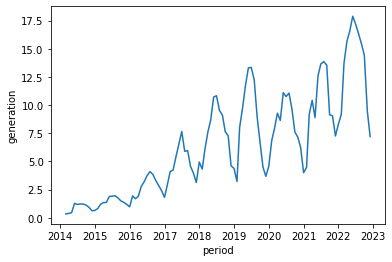

In [9]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [14]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [11]:
index

PeriodIndex(['2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07',
             '2022-06', '2022-05', '2022-04', '2022-03',
             ...
             '2014-12', '2014-11', '2014-10', '2014-09', '2014-08', '2014-07',
             '2014-06', '2014-05', '2014-04', '2014-03'],
            dtype='period[M]', name='period', length=106)

In [15]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -185.107
Date:                Sat, 18 Mar 2023   AIC                            382.214
Time:                        19:41:12   BIC                            398.195
Sample:                             0   HQIC                           388.691
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0644      1.997      3.037      0.002       2.150       9.978
ar.L1          1.5060      0.171      8.830      0.000       1.172       1.840
ar.L2         -0.5965      0.167     -3.565      0.0

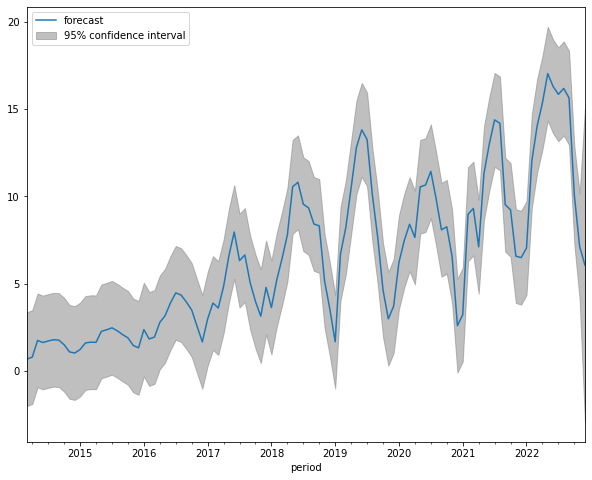

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")

Hourly Prediction

In [24]:
hourlyurl = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MISO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [25]:
try:
    (request := r.get(hourlyurl))
    print(request.text[0:1000])
except Exception as e:
    print(e)

{"response":{"warnings":[{"warning":"incomplete return","description":"The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results."}],"total":41304,"dateFormat":"YYYY-MM-DD\"T\"HH24","frequency":"hourly","data":[{"period":"2023-03-18T05","respondent":"MISO","respondent-name":"Midcontinent Independent System Operator, Inc.","fueltype":"SUN","type-name":"Solar","value":1,"value-units":"megawatthours"},{"period":"2023-03-18T04","respondent":"MISO","respondent-name":"Midcontinent Independent System Operator, Inc.","fueltype":"SUN","type-name":"Solar","value":1,"value-units":"megawatthours"},{"period":"2023-03-18T03","respondent":"MISO","respondent-name":"Midcontinent Independent System Operator, Inc.","fueltype":"SUN","type-name":"Solar","value":1,"value-units":"megawatthours"},{"period":"2023-03-18T02","respondent":"MISO","respondent-name":"Midcontinent Independent System Operator, Inc.","fuel

In [26]:
json_data = request.json()
json_data

{'response': {'warnings': [{'warning': 'incomplete return',
    'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}],
  'total': 41304,
  'dateFormat': 'YYYY-MM-DD"T"HH24',
  'frequency': 'hourly',
  'data': [{'period': '2023-03-18T05',
    'respondent': 'MISO',
    'respondent-name': 'Midcontinent Independent System Operator, Inc.',
    'fueltype': 'SUN',
    'type-name': 'Solar',
    'value': 1,
    'value-units': 'megawatthours'},
   {'period': '2023-03-18T04',
    'respondent': 'MISO',
    'respondent-name': 'Midcontinent Independent System Operator, Inc.',
    'fueltype': 'SUN',
    'type-name': 'Solar',
    'value': 1,
    'value-units': 'megawatthours'},
   {'period': '2023-03-18T03',
    'respondent': 'MISO',
    'respondent-name': 'Midcontinent Independent System Operator, Inc.',
    'fueltype': 'SUN',
    'type-name': 'Solar',
    'value': 1,
    'value-u

In [28]:
hourly_solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [30]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-03-18T05,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
1,2023-03-18T04,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
2,2023-03-18T03,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-03-18T02,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
4,2023-03-18T01,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,9,megawatthours


In [31]:
hourly_solar_generation.period = pd.to_datetime(hourly_solar_generation.period)


In [32]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-03-18 05:00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
1,2023-03-18 04:00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
2,2023-03-18 03:00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-03-18 02:00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
4,2023-03-18 01:00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,9,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

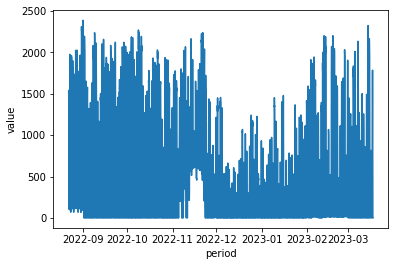

In [33]:
sns.lineplot(x="period",y="value",data=hourly_solar_generation)

In [34]:
weather_hourly_url = "https://api.weather.gov/stations/KSTL/observations"

In [35]:
try:
    (request := r.get(weather_hourly_url))
    print(request.text[0:1000])
except Exception as e:
    print(e)

{
    "@context": [
        "https://geojson.org/geojson-ld/geojson-context.jsonld",
        {
            "@version": "1.1",
            "wx": "https://api.weather.gov/ontology#",
            "s": "https://schema.org/",
            "geo": "http://www.opengis.net/ont/geosparql#",
            "unit": "http://codes.wmo.int/common/unit/",
            "@vocab": "https://api.weather.gov/ontology#",
            "geometry": {
                "@id": "s:GeoCoordinates",
                "@type": "geo:wktLiteral"
            },
            "city": "s:addressLocality",
            "state": "s:addressRegion",
            "distance": {
                "@id": "s:Distance",
                "@type": "s:QuantitativeValue"
            },
            "bearing": {
                "@type": "s:QuantitativeValue"
            },
            "value": {
                "@id": "s:value"
            },
            "unitCode": {
                "@id": "s:unitCode",
                "@type": "@id"
            },
    

In [36]:
json_data = request.json()
json_data

{'@context': ['https://geojson.org/geojson-ld/geojson-context.jsonld',
  {'@version': '1.1',
   'wx': 'https://api.weather.gov/ontology#',
   's': 'https://schema.org/',
   'geo': 'http://www.opengis.net/ont/geosparql#',
   'unit': 'http://codes.wmo.int/common/unit/',
   '@vocab': 'https://api.weather.gov/ontology#',
   'geometry': {'@id': 's:GeoCoordinates', '@type': 'geo:wktLiteral'},
   'city': 's:addressLocality',
   'state': 's:addressRegion',
   'distance': {'@id': 's:Distance', '@type': 's:QuantitativeValue'},
   'bearing': {'@type': 's:QuantitativeValue'},
   'value': {'@id': 's:value'},
   'unitCode': {'@id': 's:unitCode', '@type': '@id'},
   'forecastOffice': {'@type': '@id'},
   'forecastGridData': {'@type': '@id'},
   'publicZone': {'@type': '@id'},
   'county': {'@type': '@id'}}],
 'type': 'FeatureCollection',
 'features': [{'id': 'https://api.weather.gov/stations/KSTL/observations/2023-03-19T00:51:00+00:00',
   'type': 'Feature',
   'geometry': {'type': 'Point', 'coordina

In [69]:
json_data.get("features","1")

AttributeError: 'list' object has no attribute 'get'

In [50]:
d= json.loads(request.text)

In [97]:
for i in range(0,len(d["features"])):
    print(d["features"][i]["properties"]["timestamp"])

2023-03-19T00:51:00+00:00
2023-03-18T23:51:00+00:00
2023-03-18T22:51:00+00:00
2023-03-18T21:51:00+00:00
2023-03-18T21:04:00+00:00
2023-03-18T20:51:00+00:00
2023-03-18T19:51:00+00:00
2023-03-18T18:51:00+00:00
2023-03-18T17:51:00+00:00
2023-03-18T16:51:00+00:00
2023-03-18T15:51:00+00:00
2023-03-18T14:51:00+00:00
2023-03-18T13:51:00+00:00
2023-03-18T12:51:00+00:00
2023-03-18T11:51:00+00:00
2023-03-18T10:51:00+00:00
2023-03-18T09:51:00+00:00
2023-03-18T08:51:00+00:00
2023-03-18T07:51:00+00:00
2023-03-18T06:51:00+00:00
2023-03-18T05:51:00+00:00
2023-03-18T04:51:00+00:00
2023-03-18T03:51:00+00:00
2023-03-18T02:51:00+00:00
2023-03-18T01:51:00+00:00
2023-03-18T00:51:00+00:00
2023-03-17T23:51:00+00:00
2023-03-17T22:51:00+00:00
2023-03-17T21:51:00+00:00
2023-03-17T20:51:00+00:00
2023-03-17T19:51:00+00:00
2023-03-17T18:51:00+00:00
2023-03-17T17:51:00+00:00
2023-03-17T16:51:00+00:00
2023-03-17T15:51:00+00:00
2023-03-17T14:51:00+00:00
2023-03-17T13:51:00+00:00
2023-03-17T12:51:00+00:00
2023-03-17T1

In [98]:
for i in range(0,len(d["features"])):
    print(d["features"][i]["properties"]["temperature"]["value"])

-3.9
-3.9
-2.2
-2.8
-2.2
-2.8
-1.7
-1.7
-2.2
-2.8
-3.9
-3.9
-4.4
-5.6
-5.6
-3.9
-2.2
-0.6
0.6
2.2
1.7
1.7
1.7
1.1
2.8
4.4
5
5.6
6.7
7.2
6.1
5.6
3.9
3.3
1.7
0.6
-1.1
-1.7
-1.1
-0.6
0.6
1.7
2.2
2.8
2.8
3.3
3.3
3.9
5
5.6
6.7
7.2
None
None
None
None
None
13.3
13.3
13.3
13.3
12.8
12.8
12.8
12.8
12.8
None
12.8
13.3
13.3
13.9
13.9
15
15.6
14.4
None
None
None
17.8
17.2
15.6
13.3
12.2
9.4
9.4
10
10
9.4
8.9
8.3
8.3
8.3
8.3
8.3
8.9
9.4
10
10.6
11.7
13.9
13.9
13.9
13.3
12.2
11.7
10
7.8
5.6
3.3
1.1
0.6
0.6
-1.7
0.6
0.6
0.6
0.6
-0.6
0
0.6
2.2
2.2
5
5.6
5.6
4.4
3.3
2.2
2.2
1.7
0.6
0
-0.6
-1.1
-0.6
-0.6
-0.6
-0.6
-0.6
0
0
0.6
0.6
1.1
1.1
1
None
1.1
1.1
1.1
1.1
1.1
1.1
1.7
2.2
1.7
1.7
1.1
1.1
0.6
0
0
-0.6
-0.6
-0.6
-0.6
None
-0.6
None
0
0
0
None
0
0.6
0.6
1.7
2.2
3.3
3.9
3.9
3.9
6.1
6.7
7.2
6.1
None
6.7
6.7
6.1
5.6
5.6
5
4.4
4.4
3.9
3.9
3.9
3.9
None
4.4
4.4
4.4
4.4
None
4.4
4.4
None
4.4
None
None
4.4
4.4
4.4
4.4
4.4
None
4.4
4.4
4.4


In [102]:
for i in range(0,len(d["features"])):
    if len(d["features"][i]["properties"]["cloudLayers"]) >= 1:
        print(str(i) + d["features"][i]["properties"]["cloudLayers"][0]["amount"])

0BKN
1OVC
2BKN
3BKN
4BKN
5OVC
6BKN
7BKN
8BKN
9BKN
10BKN
11BKN
12SCT
13FEW
14SCT
15SCT
16BKN
17SCT
18SCT
19FEW
20SCT
21BKN
22CLR
23CLR
24FEW
25BKN
26BKN
27SCT
28SCT
29FEW
30FEW
31FEW
32CLR
33FEW
34FEW
35FEW
36FEW
37SCT
38SCT
39BKN
40BKN
41BKN
42OVC
43BKN
44SCT
45FEW
46SCT
47BKN
48OVC
49BKN
50OVC
51OVC
52BKN
53BKN
54FEW
55FEW
56BKN
57FEW
58FEW
59SCT
60SCT
61FEW
62FEW
63FEW
64FEW
65SCT
66FEW
67SCT
68FEW
69SCT
70SCT
71SCT
72BKN
73OVC
75OVC
76BKN
77OVC
78FEW
79OVC
80BKN
81BKN
82FEW
83FEW
84BKN
85FEW
86BKN
87BKN
88BKN
89OVC
90OVC
91BKN
92FEW
93BKN
94SCT
95BKN
96OVC
99BKN
100FEW
101FEW
102FEW
103BKN
104FEW
105SCT
106FEW
107FEW
108FEW
109FEW
110FEW
111CLR
112CLR
113CLR
114CLR
115CLR
116CLR
117CLR
118CLR
119CLR
120CLR
121FEW
122FEW
123FEW
124FEW
125FEW
126FEW
127FEW
129BKN
130OVC
131BKN
132BKN
133BKN
134OVC
135OVC
136OVC
137OVC
138OVC
140OVC
141OVC
142OVC
145OVC
146OVC
147OVC
148OVC
149OVC
150OVC
151OVC
152OVC
153OVC
154OVC
155OVC
156OVC
157FEW
158SCT
159OVC
160OVC
161BKN
162FEW
163OVC
164OVC
1

In [103]:
forecast_url = "https://api.weather.gov/gridpoints/LSX/89,80/forecast"